## To figure out
- actual SF
- calculate contrast: RMS on noise + stim or only stim?

In [1]:
import numpy as np
from psychopy.visual import GratingStim, Window
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display

pygame 2.5.2 (SDL 2.28.2, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
win = Window([1200,1200])

In [2]:
signal_parameters = {'contrast': 0.8, 'spatial_freq': 0.035, 'size': 17} # Note: size in degrees
noise_parameters =  {'contrast': 0.35, 'opacity': 0.5, 'size': 19, 'refresh_frame':2} # Note: size in degrees
win_width = 1920
mon_width = 69.8
mon_dist = 196
width_deg = 2 * np.degrees(np.arctan(mon_width / mon_dist))
width_deg

39.203911847880114

In [3]:
pix_per_deg = win_width / width_deg
stim_sizePIX = np.round(signal_parameters['size'] * pix_per_deg).astype(int)
noise_sizePIX = np.round(noise_parameters['size'] * pix_per_deg / 2).astype(int) # <= notice division by 2, it's to increase the noise element size to 2 later
stim_sizePIX
noise_sizePIX * 2

930

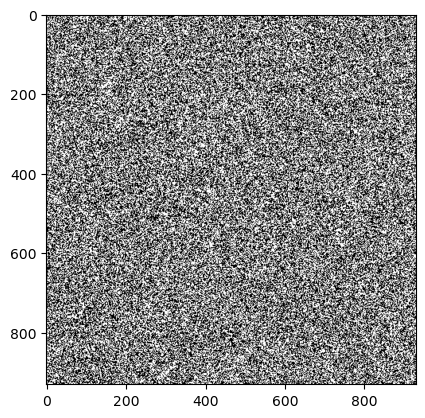

In [22]:

# Define initial values for noise stimulus. Binary noise.
noiseTexture = np.random.randint(0,2, size=[noise_sizePIX,noise_sizePIX]) *2 -1

# Duplicate values, to increase noise element size to 2
noiseTexture = np.repeat(np.repeat(noiseTexture, 2, axis=1), 2, axis=0)

#Create noise stimulus
noise = GratingStim(win, contrast= noise_parameters['contrast'], name='noise', units='pix', 
    mask='raisedCos', size=(noise_sizePIX*2, noise_sizePIX*2), opacity= noise_parameters['opacity'], 
    blendmode='avg', tex=noiseTexture)

plt.imshow(noiseTexture, cmap ='grey')

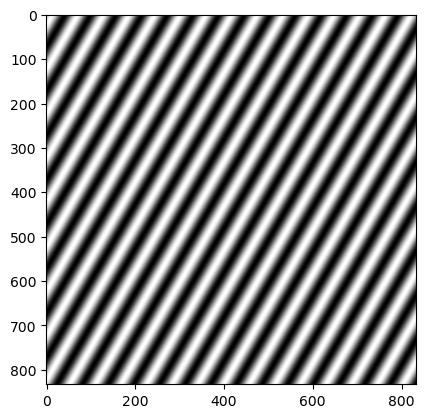

In [23]:
def make_grating(size, ori = 90, sf = 100, phase = 0):
    """
    adapted from: https://www.baskrahmer.nl/blog/generating-gratings-in-python-using-numpy
    """
    
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    # Get the appropriate gradient
    gradient = np.sin(ori * np.pi / 180) * x - np.cos(ori * np.pi / 180) * y
    # Plug gradient into wave function
    grating = np.sin((2 * np.pi * gradient) / sf + (phase * np.pi) / 180)
    
    return grating
plt.imshow(make_grating(stim_sizePIX, ori = 120, sf = 50), cmap = 'grey')

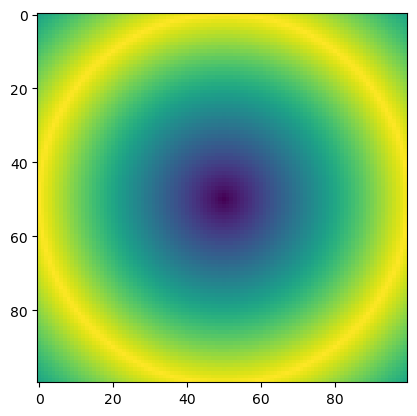

In [9]:
# make a gauss relating to eccentricity

def makeRingGaussian(size, sd = 3, r=10, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square in PX
    sd is standard deviation
    r is the radius of the ring around which the Gaussian is computed
    
    adapted from: https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    distance = np.abs(np.sqrt((x-x0)**2 + (y-y0)**2) - r)
    normalizedDist = (distance-np.min(distance))/(np.max(distance)-np.min(distance)) 

    return 1/(2*np.pi *sd**2) * np.exp(-normalizedDist / (2*sd**2)), normalizedDist
#     return np.exp(-distance / 2*sd**2), distance

gauss, dist = makeRingGaussian(100, 3, r=50)
# plt.imshow(gauss + dist)
plt.imshow(gauss)

In [10]:
# make the grating in psychopy
signal_parameters = {'contrast': 0.8, 'spatial_freq': 0.035, 'size': 17} # Note: size in degrees
mask = makeRingGaussian(stim_sizePIX,  sd=.3, r=150)[0]
grating = GratingStim(win,contrast = signal_parameters['contrast'], opacity=.25,
            tex = make_grating(stim_sizePIX, ori = 120, sf = 50) * mask, mask='raisedCos', units='pix', size=stim_sizePIX,# sf = signal_parameters['spatial_freq'],
                      color=[1,1,1]) 
# tex = 'sin'

In [24]:
noise.draw()
grating.draw()
win.flip()

2271.769278049469

In [57]:
win.close()

15.8224 	WARNING 	Monitor specification not found. Creating a temporary one...
40.2629 	ERROR 	Requiring a square power of two (e.g. 16 x 16, 256 x 256) texture but didn't receive one
40.2938 	ERROR 	numpy arrays used as textures should be in the range -1(black):1(white)
40.2939 	ERROR 	Requiring a square power of two (e.g. 16 x 16, 256 x 256) texture but didn't receive one
2271.7268 	ERROR 	Requiring a square power of two (e.g. 16 x 16, 256 x 256) texture but didn't receive one


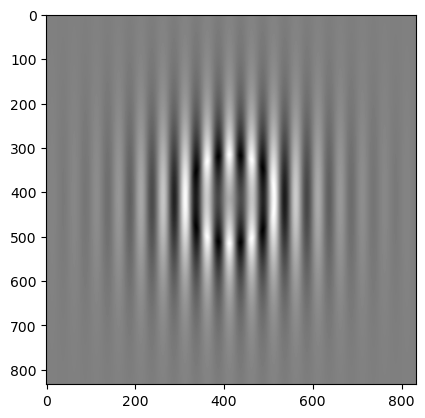

In [231]:
# show both
mask = makeRingGaussian(stim_sizePIX,  sd=.3, r=100)[0]
example_grating = make_grating(stim_sizePIX, ori = 90, sf =50)
plt.imshow(example_grating * mask, cmap = 'gray')

In [13]:
@widgets.interact(size = widgets.IntSlider(value=800, min=50, max=1200, step=1),
                  sd = widgets.FloatSlider(value=.5, min=0.1, max=1, step=0.1),
                  r = widgets.IntSlider(value=250, min=50, max=600, step=1))
def plot_2d_dist(size, sd, r):
    fig, axs = plt.subplots(1,2, figsize= (10, 20))
    gauss, dist = makeRingGaussian(size, sd, r)
    example_grating = make_grating(size, ori = 90, sf =50)
    
    axs[0].imshow(gauss)
    axs[1].imshow(example_grating * gauss, cmap = 'grey')
    
#     plt.show()

interactive(children=(IntSlider(value=800, description='size', max=1200, min=50), FloatSlider(value=0.5, descr…

## Opacity test

In [34]:
def calc_rms(texture):
    """
    see https://en.wikipedia.org/wiki/Contrast_(vision)
    """
    mean = texture.mean()
    
    rms = np.sqrt((1/(texture.shape[0] * texture.shape[1])) * np.sum((texture - mean)**2))
    return rms

def make_opaque(texture, opacity):
    
    background = .5
    opaque_texture = texture * opacity + background * (1-opacity)
    
    return opaque_texture

In [56]:
mask = makeRingGaussian(stim_sizePIX,  sd=.3, r=100)[0]
example_grating = make_grating(stim_sizePIX, ori = 90, sf =50)

@widgets.interact(opacity = widgets.FloatSlider(value=.5, min=0.0, max=1, step=0.1))
def plot_opaque(opacity):
    opaqued_tex = make_opaque(example_grating * mask, opacity) 
    plt.imshow(opaqued_tex, cmap = 'gray', vmin = -1, vmax = 1)
    plt.text(50, 50,f"rms: {calc_rms(opaqued_tex)}")

interactive(children=(FloatSlider(value=0.5, description='opacity', max=1.0), Output()), _dom_classes=('widget…

## deprecated

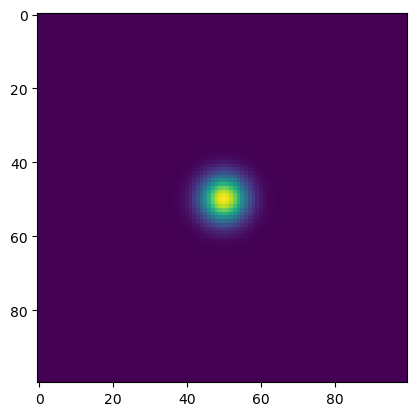

In [77]:
import numpy as np

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    can be thought of as an effective radius.
    
    from: https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    r = 50
#     return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return np.exp(-4*np.log(2) * (((x-x0)**2 + (y-y0)**2) - r) / fwhm**2)
plt.imshow(makeGaussian(100, 10, (50,50)))